In [7]:
import numpy as np 
import pandas as pd 
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
df = pd.read_csv('/kaggle/input/itstep-exam2/ship_segmentations.csv')
img_paths = '/kaggle/input/itstep-exam2/ship_images'

In [9]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [10]:
df.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [12]:
count_ships_df = df.groupby('ImageId').count()
count_ships_df

,EncodedPixels
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,1
000194a2d.jpg,5
0001b1832.jpg,0
...,...
fffedbb6b.jpg,0
ffff2aa57.jpg,0
ffff6e525.jpg,0


In [13]:
count_img_to_ships = {}
max_ships_img = count_ships_df['EncodedPixels'].max()
for i in range(0, max_ships_img +1):
    temp_count = count_ships_df[count_ships_df['EncodedPixels'] == i].count().iloc[0]
    count_img_to_ships[i] = temp_count

count_img_to_ships = pd.DataFrame(list(count_img_to_ships.items()), columns=['ShipCount', 'ImageCount'])
count_img_to_ships

,ShipCount,ImageCount
0,0,150000
1,1,27104
2,2,7674
3,3,2954
4,4,1622
5,5,925
6,6,657
7,7,406
8,8,318
9,9,243


In [14]:
total_img_with_ships = count_img_to_ships['ImageCount'].sum() - 150_000
total_img_with_ships

42556

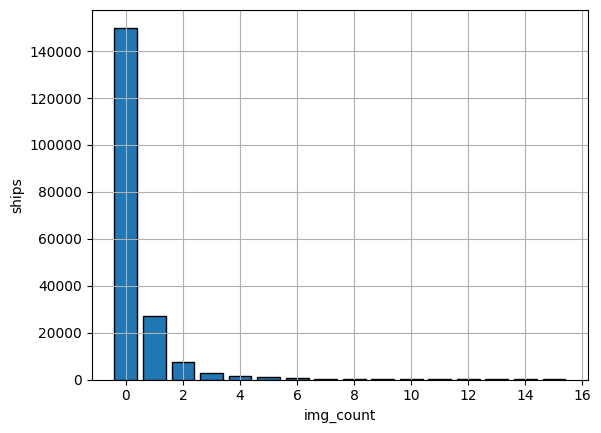

In [15]:
import matplotlib.pyplot as plt
plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.grid(True)
plt.show()

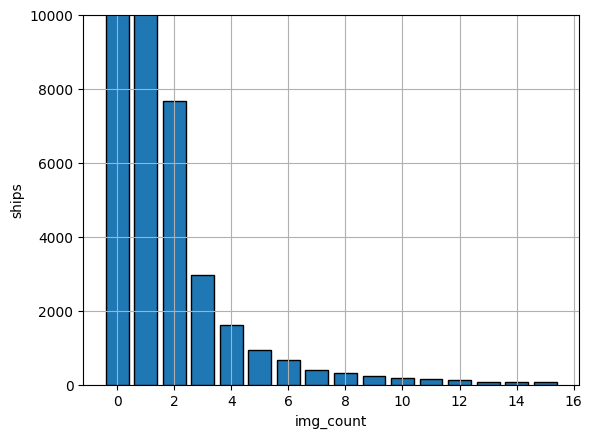

In [16]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.ylim(0, 10_000)
plt.grid(True)
plt.show()

In [31]:
wout_ships = df[df['EncodedPixels'].isna()]
with_ships = df[df['EncodedPixels'].notna()]

reduced_wout_ships = wout_ships.sample(5_000) 
reduced_with_ships = with_ships.sample(15_000)

balanced_df = pd.concat([reduced_with_ships, reduced_wout_ships])
balanced_df = balanced_df.sample(frac=1)
balanced_df

,ImageId,EncodedPixels
62222,44d40119e.jpg,139511 1 140277 4 141043 6 141809 9 142576 10 ...
178398,c518f2ea2.jpg,149929 2 150694 5 151459 9 152224 12 152989 15...
182217,c93eace5b.jpg,189521 4 190289 4 191057 4 191825 4 192593 5 1...
78448,56acec5f0.jpg,NaN
128415,8da931695.jpg,409762 2 410528 4 411294 7 412060 9 412826 12 ...
...,...,...
127796,8d027843e.jpg,NaN
6043,069813b2d.jpg,3893 2 4657 6 5422 10 6188 12 6956 12 7725 11 ...
69660,4d2ebf1ac.jpg,362631 5 363399 5 364167 5 364935 5 365703 5 3...
119975,84672e2e7.jpg,126873 8 127625 24 128377 40 129129 56 129890 ...


In [32]:
def rle_to_mask(rle, shape):
    """
    converting RLE string into a mask.

    Parameters:
    rle (str): rle string (format "start1 length1 start2 length2 ...")
    shape (tuple): mask shape (height, width)

    Returns:
    numpy.ndarray: mask as 2D numpy array
    """

    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    if rle == 'nan':
        return mask.reshape(shape)

    rle_nums = list(map(int, rle.split()))

    starts = rle_nums[0::2]
    lengths = rle_nums[1::2]

    starts = [start -1  for start in starts]

    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1

    return mask.reshape(shape).T

def combine_rle_masks(rles, shape):
    """
    Combines several RLE masks into one.

    Parameters:
    rles (list of str): list of rle strings
    shape (tuple): mask shape (height, width)

    Returns:
    torch.Tensor: combined mask as a 2D tensor
    """
    combined_mask = np.zeros(shape, dtype=np.uint8)
    
    for rle in rles:
        mask = rle_to_mask(rle, shape)
        combined_mask = np.maximum(combined_mask, mask)
    
    tensor_combined_mask = torch.tensor(combined_mask, dtype=torch.uint8)
    
    return tensor_combined_mask

In [33]:
shape = (768, 768)
masks = {}

balanced_df['EncodedPixels'] = balanced_df['EncodedPixels'].astype(str)
grouped_data = balanced_df.groupby('ImageId')

for img_id, group in grouped_data:
    rles = group['EncodedPixels'].tolist()
    masks[img_id] = combine_rle_masks(rles, shape)


In [36]:
for image_id, mask in masks.items():
    print(f"Image ID: {image_id}")
    print(mask)
    break

Image ID: 000155de5.jpg
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
